# 모델 생성
- 앞에 선택한 데이터들을 이용하여 전력량을 예측하는 모델을 생성
- 독립변수 : 지역코드, 최저기온(°C), 3.0m 지중온도(°C), 평균 현지기압(hPa), 가조시간(hr), 평균 상대습도(%), 풍정합(100m), 합계 소형증발량(mm)
- 타겟변수 : 파워 (전력량)

## 모델 생성을 위한 훈련데이터

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [60]:
df = pd.read_csv('data\훈련데이터셋.csv')
df.head(1)

,지역코드,최저기온(°C),3.0m 지중온도(°C),평균 현지기압(hPa),가조시간(hr),평균 상대습도(%),풍정합(100m),합계 소형증발량(mm),파워
0,1111010100,-5.2,18.4,1020.9,9.7,38.9,2386.0,1.7,146294.6135


### 데이터셋을 train, test로 나누기

In [61]:
X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

((181408, 8), (181408,))

In [62]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((145126, 8), (36282, 8), (145126,), (36282,))

### 훈련데이터 전처리
- 지역코드는 원핫인코딩 처리
- 나머지는 정규화 처리

행 당 한개의 정규화 모델을 만들기에는 너무 많은 정규화 모델이 만들어지고 이를 하나하나 다 저장하기에는 힘들기에 sklear의 ColumnTransformer를 사용

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), ['지역코드']), 
                ('standardScaler', StandardScaler(), [col for col in X.columns if col!='지역코드'])]
    )

In [64]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [65]:
# 전처리 모델 저장하기
import joblib
joblib.dump(preprocessor, 'model/preprocessor.joblib')

['model/preprocessor.joblib']

## 모델 생성 (DNN)

### 간단한 모델
- 간단한 모델 하나를 만들어 훈련시간과 결과를 보기

In [66]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [67]:
X_train_preprocessed.toarray().shape, y_train.shape

((145126, 473), (145126,))

In [71]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               242688    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)               

In [72]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = './model/SimpleDNN/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(X_train_preprocessed.toarray(), y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3629/3629 [==============================] - 12s 3ms/step - loss: 57504354304.0000 - mae: 57615.9375 - mse: 57504354304.0000 - val_loss: 37176348672.0000 - val_mae: 46411.3867 - val_mse: 37176348672.0000
Epoch 2/100
3629/3629 [==============================] - 12s 3ms/step - loss: 40533250048.0000 - mae: 38305.8086 - mse: 40533250048.0000 - val_loss: 35056967680.0000 - val_mae: 46048.3008 - val_mse: 35056967680.0000
Epoch 3/100
3629/3629 [==============================] - 12s 3ms/step - loss: 39194206208.0000 - mae: 37348.4336 - mse: 39194206208.0000 - val_loss: 32927889408.0000 - val_mae: 32074.4199 - val_mse: 32927889408.0000
Epoch 4/100
3629/3629 [==============================] - 12s 3ms/step - loss: 39177621504.0000 - mae: 36235.8633 - mse: 39177621504.0000 - val_loss: 30833520640.0000 - val_mae: 32426.8477 - val_mse: 30833520640.0000
Epoch 5/100
3629/3629 [==============================] - 12s 3ms/step - loss: 36666294272.0000 - mae: 35336.4062 - mse: 36666294272.0000

In [ ]:
# 테스트 해보기
X_test_preprocessor = preprocessor.transform(X_test)
test_loss, test_mae, test_mse = model.evaluate(X_test_preprocessor.toarray(), y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 25272973312.00
  MAE: 26626.93
  RMSE: 158974.76


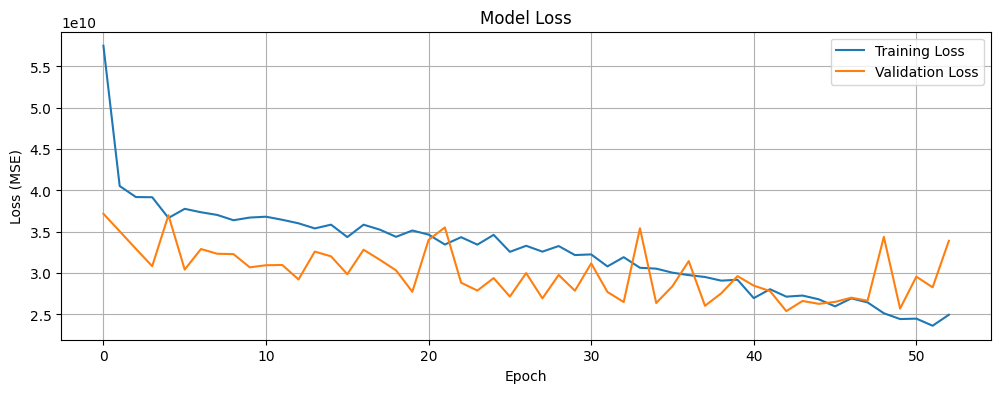

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)